# Image Thresholding and Center of Mass Calculation

This notebook demonstrates how to perform image thresholding and calculate the center of mass of the thresholded image. Image thresholding is a technique used to segment an image by setting all pixels below a certain intensity to zero and all pixels above that intensity to a maximum value. The center of mass calculation helps in identifying the geometric center of the thresholded region.

## Load the images and imports

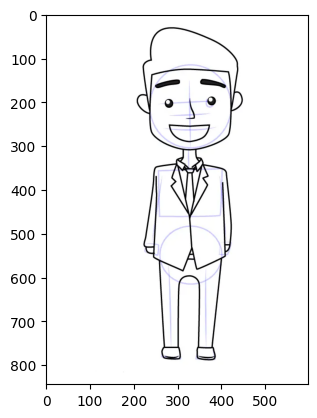

In [1]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

man = cv2.imread("drawings/man.png")
plt.imshow(cv2.cvtColor(man, cv2.COLOR_BGR2RGB))

## Perform a binary threshold on the image
This converts the image to only two colors, allowing the algorithm to classify it more easily

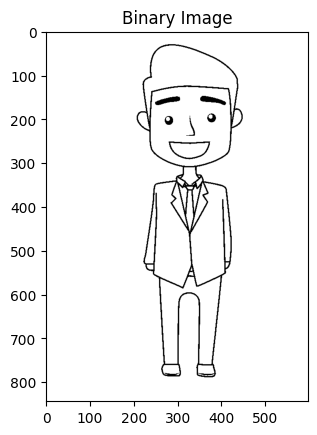

In [2]:
# Convert the image to grayscale
gray_man = cv2.cvtColor(man, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary_man = cv2.threshold(gray_man, 127, 255, cv2.THRESH_BINARY)

# Display the binary image
plt.imshow(binary_man, cmap='gray')
plt.title('Binary Image')
plt.show()

## Edge Detection
Find the edges of the binary image using the Sobel operator.

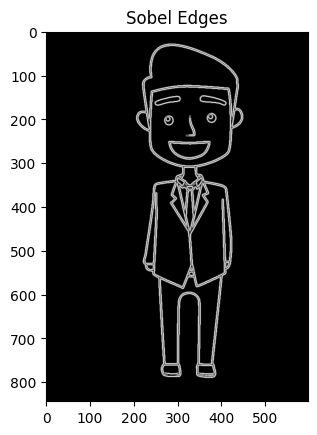

In [3]:
# Apply Sobel operator to find edges
sobelx = cv2.Sobel(binary_man, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(binary_man, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges = np.sqrt(sobelx**2 + sobely**2)

# Display the edges
plt.imshow(sobel_edges, cmap='gray')
plt.title('Sobel Edges')
plt.show()

### Use the Convex Hull Algorithm To Simplify the Shape
Using the CVH algorithm, find the smallest line that encircles the entire image

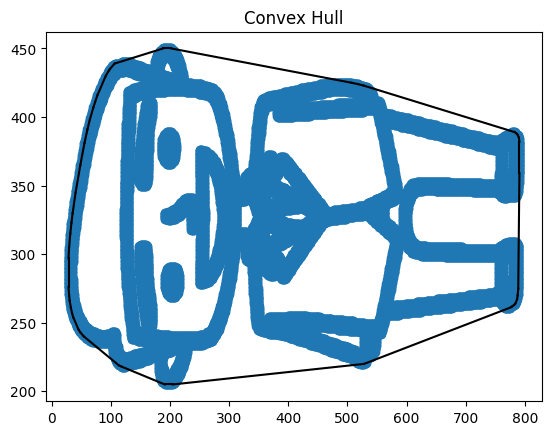

In [4]:
from scipy.spatial import ConvexHull
points = np.column_stack(np.where(sobel_edges > 0))


hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
plt.title('Points in the image')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.title('Convex Hull')
plt.show()

## Find the center
Find the center of the image

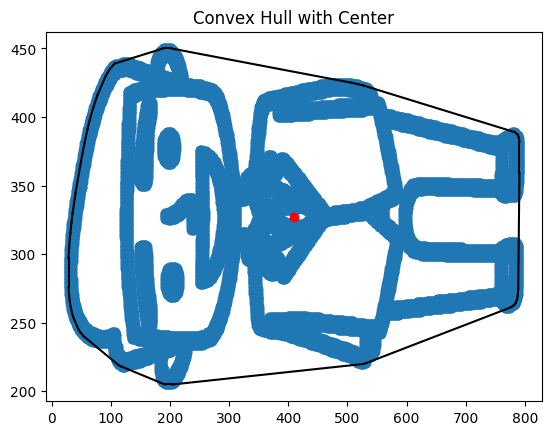

In [5]:
x = hull.max_bound[0] - hull.min_bound[0]
y = hull.max_bound[1] - hull.min_bound[1]
center = (x//2 + hull.min_bound[0], y//2 + hull.min_bound[1])
# Plot the center on the convex hull
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.plot(center[0], center[1], 'ro')  # Plot the center as a red dot
plt.title('Convex Hull with Center')
plt.show()

### Interpolate the hull
Treating the hull as a spline, convert it to a set of points

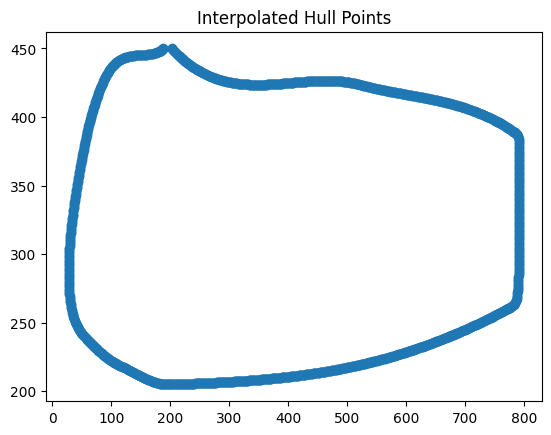

In [6]:
from scipy.interpolate import splprep, splev

# Extract the hull points
hull_points = points[hull.vertices]

# Create a parameterization of the hull points
tck, u = splprep([hull_points[:, 0], hull_points[:, 1]], s=0)

# Define the number of points you want on the hull
num_points = 1500

# Generate new points on the hull
new_points = splev(np.linspace(0, 1, num_points), tck)

# Convert the new points to a numpy array
new_hull_points = np.column_stack(new_points)

# Plot the new hull points
plt.plot(new_hull_points[:, 0], new_hull_points[:, 1], 'o')
plt.title('Interpolated Hull Points')
plt.show()

### Find the outline
Shrink fit the spline by moving all points towards the center until they touch the outline of the original image

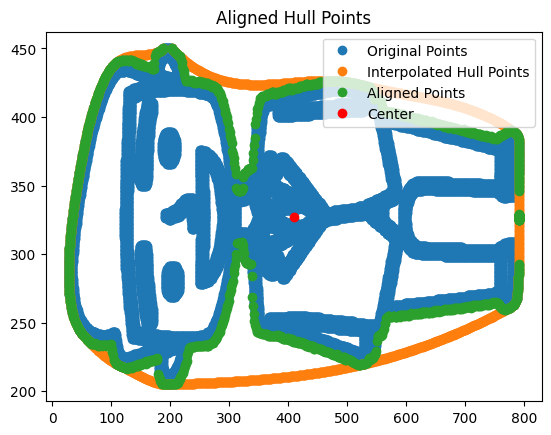

In [7]:
step = 1  # Define the step value
threshold = 2  # Define the threshold value

# Function to move points towards the center
def move_points_towards_center(points, center, step, threshold, edge_points):
    moved_points = []
    for point in points:
        while True:
            if np.any(np.all(np.isclose(edge_points, point, atol=threshold), axis=1)):
                break
            if abs(point[1] - center[1]) <= threshold:
                break
            if point[1] > center[1]:
                point[1] -= step
            else:
                point[1] += step
        moved_points.append(point)
    return np.array(moved_points)

# Move the interpolated hull points towards the center
aligned_points = move_points_towards_center(new_hull_points.copy(), center, step, threshold, np.column_stack(np.where(sobel_edges > 0)))

# Plot the aligned points
plt.plot(points[:, 0], points[:, 1], 'o', label='Original Points')
plt.plot(new_hull_points[:, 0], new_hull_points[:, 1], 'o', label='Interpolated Hull Points')
plt.plot(aligned_points[:, 0], aligned_points[:, 1], 'o', label='Aligned Points')
plt.plot(center[0], center[1], 'ro', label='Center')
plt.legend()
plt.title('Aligned Hull Points')
plt.show()

In [8]:
aligned_points.shape

(1500, 2)

### Create Outline Spline
Reorder the points by distance from eachother, and convert them to a spline to connect the holes
(Removes any erroneous points outside a specific threshold)

In [12]:
from scipy.spatial.distance import cdist

# Ensure the points are unique
aligned_points = np.unique(aligned_points, axis=0)

# Convert the aligned points to integers
aligned_points = aligned_points.astype(int)

# Function to reorder points to be next to their closest neighbors
def reorder_points(points):
    if len(points) < 2:
        return points
    ordered_points = [points[0]]
    points = points[1:]
    while len(points) > 0:
        last_point = ordered_points[-1]
        distances = cdist([last_point], points)
        nearest_index = np.argmin(distances)
        if distances[0, nearest_index] > threshold:
            break
        ordered_points.append(points[nearest_index])
        points = np.delete(points, nearest_index, axis=0)
    return np.array(ordered_points)

# Define the threshold value
threshold = 50.0

# Reorder the aligned points
aligned_points_sorted = reorder_points(aligned_points)

In [13]:
aligned_points_sorted.shape

(1459, 2)

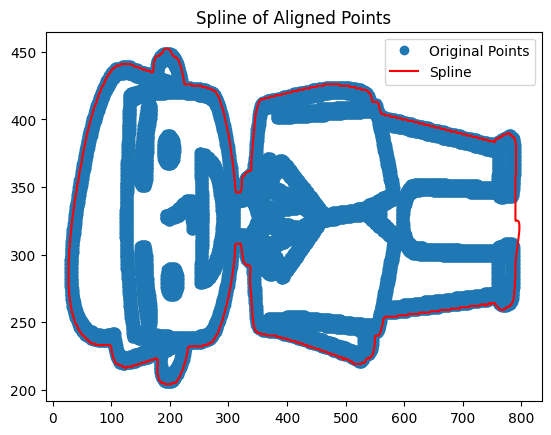

In [101]:
# Create a spline of the aligned points
tck, u = splprep([aligned_points_sorted[:, 0], aligned_points_sorted[:, 1]], s=0)

# Interpolation accuracy (number of points)
num_points2 = 2000

new_points = splev(np.linspace(0, 1, num_points2), tck)

# Plot the original points and the spline
plt.plot(points[:, 0], points[:, 1], 'o', label='Original Points')
plt.plot(new_points[0], new_points[1], 'r-', label='Spline')
plt.title('Spline of Aligned Points')
plt.legend()
plt.show()

### Push the spline into 3D space
Assign depth values according to a user specified maeasurement and project the spline into a point cloud

In [97]:
import open3d as o3d

# Define the user-specified depth value
depth_value = 500  # You can change this value as needed

# Duplicate the points to replicate depth
# Create the depth points using np.tile
depth_points = np.vstack((
    np.tile(new_points[0], depth_value),
    np.tile(new_points[1], depth_value),
    np.repeat(np.arange(depth_value), len(new_points[0]))
))

# Convert the depth points into a point cloud
threed_points = np.column_stack(depth_points)

# Create an Open3D point cloud object
point_cloud = o3d.geometry.PointCloud()

point_cloud.points = o3d.utility.Vector3dVector(threed_points)

# Visualize the point cloud
o3d.visualization.draw_geometries([point_cloud])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
